# Calculate persistence correlation coefficients as a benchmark of predictability

### Author - Chris Wyburn-Powell, see the latest version on [github](https://github.com/chrisrwp/low-frequency-variability/blob/main/predict/Null_model_persistence.ipynb)


**Input:**
- `CMIP6_modeling_center_members_doi.nc`
- `Regional_SIC_SIT_all_mem_<model_name>_1850_2014.nc`
- `Regional_SIC_detrended_lowpass_filter_<model_name>_1920_2014.nc`
- `Regional_SIC_lowpass_filter_CESM2-lessmelt_1920_2014.nc`
- `Regional_SIC_detrended_lowpass_filter_HadISST1_1920_2022.nc`
- `Regional_SIC_lowpass_filter_PI_Control_MMLE_500.nc`

**Method:**
- Regional sea ice concentration (SIC) 1920-2014 for all CMIP6 GCMs which appear in the CVDP historical groups A,B,C. Calculations are based on both the raw SIC data and the 2 year lowpass filtered data. Produce Pearson correlation coefficients for all GCM members, by region, month of the year, and lag time of 1-20 years.

**Output:**
- `Pearson_correlation_SIC_lagged_1_20_years_linear_detrended_1920_2014_lowpass_filt_HadISST1_for_1956_2022.nc`
- `Pearson_correlation_SIC_lagged_1_20_years_lowpass_PI_Control.nc`
- `Pearson_correlation_SIC_lagged_1_20_years_<model_name>.nc`
- `Pearson_correlation_SIC_lagged_1_20_years_lowpass_<model_name>.nc`
- `Regional_SIC_lowpass_filter_CESM2-lessmelt_1920_2014.nc`
  

In [1]:
import numpy as np
import xarray as xr
import scipy.signal as signal
import matplotlib.pyplot as plt
import datetime
import dask

In [2]:
CMIP6_info = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
    +'CMIP6_modeling_center_members_doi.nc'
)

## Compute persistence correlation based on raw SIC data (not lowpass filtered)

In [7]:
var_ = 'regional_SIC'

corr_SIC = {}

for model_name in CMIP6_info['model'].drop_sel(model=['CAS-ESM2-0']).values:
    print(datetime.datetime.now(), model_name)
    
    try:
        model_data = xr.open_dataset(
            f'/glade/work/cwpowell/low-frequency-variability/raw_data/'
            f'regional_sea_ice_CMIP6/Regional_SIC_SIT_all_mem_{model_name}_'
            f'1850_2014.nc'
        )
        
        
    except (FileNotFoundError):
        print(model_name,'FILE NOT FOUND')
        continue
        
        
    all_mems = []
    for mem_ in np.sort(model_data['member'].values):
        print(datetime.datetime.now(), mem_)
        all_regions = []
        for region_ in [1,2,3,4,5,6,11]:
            all_months = []
            for month_ in np.arange(1,13):
                all_lags = []
                for lag_ in np.arange(1,21):
                    month_region = model_data[var_].sel(member=mem_).sel(time=
                        model_data['time.month']==month_).sel(region=region_)

                    #select the base time period
                    sea_ice_init = month_region.sel(
                        time=slice('1920',str(2014-lag_)))
                    sea_ice_init['time'] = range(len(sea_ice_init['time']))
                    #select a lagged time period but use same time coordinates
                    sea_ice_lagged = month_region.sel(
                        time=slice(str(1920+lag_),'2014'))
                    sea_ice_lagged['time'] = range(len(sea_ice_lagged['time']))
                    all_lags.append(xr.corr(sea_ice_init, sea_ice_lagged))

                all_lags_xr = xr.concat((all_lags),dim='lag')
                all_lags_xr['lag'] = np.arange(1,21)
                all_months.append(all_lags_xr)

            all_months_xr = xr.concat((all_months),dim='month')
            all_months_xr['month'] = np.arange(1,13)
            all_regions.append(all_months_xr)

        all_regions_xr = xr.concat((all_regions),dim='region')
        all_regions_xr['region'] = [1,2,3,4,5,6,11]
        all_mems.append(all_regions_xr)

    all_mems_xr = xr.concat((all_mems),dim='member')
    all_mems_xr['member'] = np.sort(model_data['member'].values)
    corr_SIC[model_name] = all_mems_xr
    
    
            

In [29]:
for model_name in np.sort(list(corr_SIC.keys())):
    doi_model = doi_model = CMIP6_info['doi'].sel(model=model_name)
    model_corr = xr.Dataset({'r_value':corr_SIC[model_name]})
    model_corr.attrs = {
        'Description': 'Pearson correlation coefficient between sea ice '\
            f'thickness in {model_name} historical forcing 1920-2014 and '\
            'the same data lagged by 1-20 years, by region, lag and member',
        'Timestamp'  : str(datetime.datetime.utcnow().strftime(
            "%H:%M UTC %a %Y-%m-%d")),
        'Data source': '{}, doi:{} . '.format(model_name, doi_model), 
        'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
            'blob/main/null_model/Null_model_persistence.ipynb'
    }
    
    model_corr.to_netcdf(
        '/glade/work/cwpowell/low-frequency-variability/null_model/'
        f'Pearson_correlation_SIT_lagged_1_20_years_{model_name}.nc'
    )

## Now compute Pearson correlation coefficient for lowpass filtered data

In [4]:
for model_name in CMIP6_info['model'].values:
    print('\n',datetime.datetime.now(), model_name)
    
    if model_name in ['CAS-ESM2-0','FGOALS-f3-L','FGOALS-g3']:
        continue
    
    try:
        model_data = xr.open_dataset(
            f'/glade/work/cwpowell/low-frequency-variability/input_data/'
            f'Regional_SIC_detrended_lowpass_filter_{model_name}_1920_2014.nc'
        )
        
    except (FileNotFoundError):
        print(model_name,'FILE NOT FOUND')
        continue
        
    all_mems = []
    for mem_ in np.sort(model_data['member'].values):
        print(mem_, end=',')
        all_regions = []
        for region_ in [1,2,3,4,5,6,11]:
            all_months = []
            for month_ in np.arange(1,13):
                all_lags = []
                for lag_ in np.arange(1,21):
                    month_region = model_data['SIC'].sel(member=mem_).sel(
                        month=month_).sel(region=region_)

                    #select the base time period
                    sea_ice_init = month_region.sel(
                        year=slice('1920',str(2014-lag_)))
                    sea_ice_init['year'] = range(len(sea_ice_init['year']))
                    #select a lagged time period but use same time coordinates
                    sea_ice_lagged = month_region.sel(
                        year=slice(str(1920+lag_),'2014'))
                    sea_ice_lagged['year'] = range(len(sea_ice_lagged['year']))
                    all_lags.append(xr.corr(sea_ice_init, sea_ice_lagged))

                all_lags_xr = xr.concat((all_lags),dim='lag')
                all_lags_xr['lag'] = np.arange(1,21)
                all_months.append(all_lags_xr)

            all_months_xr = xr.concat((all_months),dim='month')
            all_months_xr['month'] = np.arange(1,13)
            all_regions.append(all_months_xr)

        all_regions_xr = xr.concat((all_regions),dim='region')
        all_regions_xr['region'] = [1,2,3,4,5,6,11]
        all_mems.append(all_regions_xr)

    all_mems_xr = xr.concat((all_mems),dim='member')
    all_mems_xr['member'] = np.sort(model_data['member'].values)
        
    
    doi_model = CMIP6_info['doi'].sel(model=model_name)
    model_corr = xr.Dataset({'r_value':all_mems_xr})
    model_corr.attrs = {
        'Description': 'Pearson correlation coefficient between sea ice '\
            f'concentration in {model_name} historical forcing 1920-2014 '\
            'with a 2 year lowpass filter. The same data is lagged by 1-20 '\
            'years, evaluated by region and member',
        'Timestamp'  : str(datetime.datetime.utcnow().strftime(
            "%H:%M UTC %a %Y-%m-%d")),
        'Data source': '{}, doi:{} . '.format(model_name, doi_model), 
        'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
            'blob/main/null_model/Null_model_persistence.ipynb'
    }
    
    model_corr.to_netcdf(
        '/glade/work/cwpowell/low-frequency-variability/null_model/'
        f'Pearson_correlation_SIC_lagged_1_20_years_lowpass_{model_name}.nc'
    )

In [7]:
for model_name in CMIP6_info['model'].drop_sel(model=[
    'CAS-ESM2-0','FGOALS-f3-L','FGOALS-g3']).values:
    print(datetime.datetime.now(), model_name)
    
    try:
        model_data = xr.open_dataset(
            '/glade/work/cwpowell/low-frequency-variability/input_data/'\
            f'Regional_SIC_bandpass_2_40_year_{model_name}_1920_2014.nc'
        )
        
    except (FileNotFoundError):
        print(model_name,'FILE NOT FOUND')
        continue
        
    all_mems = []
    for mem_ in np.sort(model_data['member'].values):
        all_regions = []
        for region_ in [1,2,3,4,5,6,11]:
            all_months = []
            for month_ in np.arange(1,13):
                all_lags = []
                for lag_ in np.arange(1,21):
                    month_region = model_data['SIC'].sel(member=mem_).sel(
                        month=month_).sel(region=region_)

                    #select the base time period
                    sea_ice_init = month_region.sel(
                        year=slice('1920',str(2014-lag_)))
                    sea_ice_init['year'] = range(len(sea_ice_init['year']))
                    #select a lagged time period but use same time coordinates
                    sea_ice_lagged = month_region.sel(
                        year=slice(str(1920+lag_),'2014'))
                    sea_ice_lagged['year'] = range(len(sea_ice_lagged['year']))
                    all_lags.append(xr.corr(sea_ice_init, sea_ice_lagged))

                all_lags_xr = xr.concat((all_lags),dim='lag')
                all_lags_xr['lag'] = np.arange(1,21)
                all_months.append(all_lags_xr)

            all_months_xr = xr.concat((all_months),dim='month')
            all_months_xr['month'] = np.arange(1,13)
            all_regions.append(all_months_xr)

        all_regions_xr = xr.concat((all_regions),dim='region')
        all_regions_xr['region'] = [1,2,3,4,5,6,11]
        all_mems.append(all_regions_xr)

    all_mems_xr = xr.concat((all_mems),dim='member')
    all_mems_xr['member'] = np.sort(model_data['member'].values)
        
    
    doi_model = CMIP6_info['doi'].sel(model=model_name)
    model_corr = xr.Dataset({'r_value':all_mems_xr})
    model_corr.attrs = {
        'Description': 'Pearson correlation coefficient between sea ice '\
            f'concentration in {model_name} historical forcing 1920-2014 '\
            'with a 2 to 40-year bandpass filter. The same data is lagged by '\
            '1-20 years, evaluated by region and member',
        'Timestamp'  : str(datetime.datetime.utcnow().strftime(
            "%H:%M UTC %a %Y-%m-%d")),
        'Data source': '{}, doi:{} . '.format(model_name, doi_model), 
        'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
            'blob/main/null_model/Null_model_persistence.ipynb'
    }
    
    model_corr.to_netcdf(
        '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'
        f'correlation_SIC_lagged_1_20_years_bandpass_2_40_{model_name}.nc'
    )

## Compute persistence on the observations

In [3]:
obs_data = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    'Regional_SIC_detrended_lowpass_filter_HadISST1_1920_2022.nc'
)
        

all_regions = []
for region_ in [1,2,3,4,5,6,11]:
    all_months = []
    for month_ in np.arange(1,13):
        all_lags = []
        for lag_ in np.arange(1,21):
            month_region = obs_data['regional_SIC'].sel(month=month_).sel(
                region=region_)

            #select the base time period
            sea_ice_init = month_region.sel(
                year=slice('1956',str(2022-lag_)))
            sea_ice_init['year'] = range(len(sea_ice_init['year']))
            #select a lagged time period but use same time coordinates
            sea_ice_lagged = month_region.sel(
                year=slice(str(1956+lag_),'2022'))
            sea_ice_lagged['year'] = range(len(sea_ice_lagged['year']))
            all_lags.append(xr.corr(sea_ice_init, sea_ice_lagged))

        all_lags_xr = xr.concat((all_lags),dim='lag')
        all_lags_xr['lag'] = np.arange(1,21)
        all_months.append(all_lags_xr)

    all_months_xr = xr.concat((all_months),dim='month')
    all_months_xr['month'] = np.arange(1,13)
    all_regions.append(all_months_xr)

all_regions_xr = xr.concat((all_regions),dim='region')
all_regions_xr['region'] = [1,2,3,4,5,6,11]   

In [4]:
obs_corr = xr.Dataset({'r_value':all_regions_xr})
obs_corr.attrs = {
    'Description': 'Pearson correlation coefficient between sea ice '\
        f'concentration in HadISST1 1956-2022, linearly detrended and 2-year '\
        'lowpass filter data using the trend for 1920-2014. '\
        'The same data is lagged by 1-20 years, evaluated by '\
        'region as per the NSIDC MASIE regions.',
    'Timestamp'  : str(datetime.datetime.utcnow().strftime(
        "%H:%M UTC %a %Y-%m-%d")),
    'Data source': 'HadISST1, doi:10.1029/2002JD002670.', 
    'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
        'blob/main/null_model/Null_model_persistence.ipynb'
}

obs_corr.to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'\
    'correlation_SIC_lagged_1_20_years_linear_detrended_1920_2014_lowpass_'
    'filt_HadISST1_for_1956_2022.nc'
)

## CESM2-lessmelt

In [2]:
xr_new_time = xr.open_dataarray(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
    +'datetime64_1850_2100_monthly.nc')

In [3]:
#load the CESM region mask
region_mask = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
    +'masie_masks/masiemask_CESM2-LENS.nc'
)

#load the areacello file
areacello_ = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/'\
    +'raw_data/masie_masks/areacello_CESM2-LENS_30N.nc'
)
region_mask = region_mask.rename({'nlat':'nj', 'nlon':'ni'})
region_mask = region_mask.drop('lat_2').drop('lon_2')
areacello_ = areacello_.rename({'nlat':'nj', 'nlon':'ni'})

areacello_with_nan = areacello_['areacello']

In [32]:
def CESM2_lessmelt_region_extract(data_, start_yr, end_yr):
    
    SIC = data_['aice'].where(areacello_with_nan, drop=False)
    SIC = SIC.sortby('time')        
    SIC = SIC.sel(time=slice(str(start_yr)+'-02', str(end_yr+1)+'-01')) 

    SIC['time'] = xr_new_time.sel(time=slice(str(start_yr),str(end_yr)))
    
    xr_new_time_nan = xr_new_time.sel(
        time=slice(str(start_yr), str(end_yr))).astype(int).where(
        xr_new_time.sel(time=slice(str(start_yr), str(end_yr))).astype(
            int)==0.01,0)*np.nan

    SIC = SIC.where(SIC>0).sel(time=slice('1920','2014'))

    #calculate regional data
    SIA_regions = []
    SIC_regions_av = []

    for region_ in np.arange(1,17):
        area_region = areacello_with_nan.where(
                region_mask['regions']==region_).sum()

        SIC_region = SIC.where((region_mask['regions']==region_))
        SIA_region = (SIC_region * areacello_with_nan).sum('nj').sum('ni')

        SIA_regions.append(SIA_region)
        SIC_regions_av.append(SIA_region / area_region)

    #concat all regions
    SIA_regions =  xr.concat((SIA_regions),dim='region')
    SIA_regions['region'] = np.arange(1,17)
    SIC_regions_av = xr.concat((SIC_regions_av),dim='region')
    SIC_regions_av['region'] = np.arange(1,17)

    SIA_SIC_xr = xr.Dataset(
            {'regional_SIA':SIA_regions, 'regional_SIC':SIC_regions_av}
        )
    
    return SIA_SIC_xr
    

In [33]:
base_path = '/glade/campaign/cgd/ppc/cesm2_tuned_albedo/b.e21.BHIST.f09_g17.'\
    +'CMIP6-historical.0'

all_SIA_SIC = []

for var_ID in [12]:
    print(datetime.datetime.now(), var_ID)

    SIC_a = xr.open_dataset(
        base_path+f'{var_ID}/ice/proc/tseries/Kayetal22/b.e21.BHIST.f09_g17'\
        f'.CMIP6-historical.0{var_ID}.cice.h.aice.190001-194912.nc')
    
    SIC_b = xr.open_dataset(
       base_path+f'{var_ID}/ice/proc/tseries/Kayetal22/b.e21.BHIST.f09_g17'\
        f'.CMIP6-historical.0{var_ID}.cice.h.aice.195001-199912.nc')
    
    SIC_c = xr.open_dataset(
        base_path+f'{var_ID}/ice/proc/tseries/Kayetal22/b.e21.BHIST.f09_g17'\
        f'.CMIP6-historical.0{var_ID}.cice.h.aice.200001-201412.nc')

    SIC = xr.concat((SIC_a, SIC_b, SIC_c), dim='time')
    all_SIA_SIC.append(CESM2_lessmelt_region_extract(SIC, 1900, 2014))
    
for var_ID in [13,14,15]:
    print(datetime.datetime.now(), var_ID)

    SIC_a = xr.open_dataset(
        base_path+f'{var_ID}/ice/proc/tseries/Kayetal22/b.e21.BHIST.f09_g17'\
        f'.CMIP6-historical.0{var_ID}.cice.h.aice.192001-196912.nc')
    
    SIC_b = xr.open_dataset(
       base_path+f'{var_ID}/ice/proc/tseries/Kayetal22/b.e21.BHIST.f09_g17'\
        f'.CMIP6-historical.0{var_ID}.cice.h.aice.197001-201412.nc')

    SIC = xr.concat((SIC_a, SIC_b), dim='time')
    all_SIA_SIC.append(CESM2_lessmelt_region_extract(SIC, 1920, 2014))

for var_ID in np.arange(18,23):
    print(datetime.datetime.now(), var_ID)

    SIC_a = xr.open_dataset(
        base_path+f'{var_ID}/ice/proc/tseries/month_1/b.e21.BHIST.f09_g17.'\
        f'CMIP6-historical.0{var_ID}.cice.h.aice.192001-196912.nc')

    SIC_b = xr.open_dataset(
        base_path+f'{var_ID}/ice/proc/tseries/month_1/b.e21.BHIST.f09_g17.'\
        f'CMIP6-historical.0{var_ID}.cice.h.aice.197001-201412.nc')

    SIC = xr.concat((SIC_a, SIC_b), dim='time')
    all_SIA_SIC.append(CESM2_lessmelt_region_extract(SIC, 1920, 2014))

2023-04-27 17:36:02.045231 12
2023-04-27 17:36:48.954625 13
2023-04-27 17:37:31.163759 14
2023-04-27 17:38:14.300086 15
2023-04-27 17:38:57.777704 18
2023-04-27 17:39:42.422378 19
2023-04-27 17:40:26.636467 20
2023-04-27 17:41:08.260625 21
2023-04-27 17:41:50.256952 22


In [36]:
all_tuned_ice = xr.concat((all_SIA_SIC),dim='member')
all_tuned_ice['member'] = [12,13,14,15,18,19,20,21,22]

In [37]:
all_tuned_ice.to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/null_model/'\
    f'Regional_SIC_CESM2-lessmelt_1920_2014.nc'
)

In [39]:
all_tuned_ice = xr.concat(
    (all_tuned_ice.sel(region=6),
     all_tuned_ice.sel(region=[1,2,3,4,5,11])
     /all_tuned_ice.sel(region=[1,2,3,4,5,11]).max('time')), dim='region'
    )

In [75]:
#open and linearly detrend and lowpass filter the SIC
filtered_xr_list = []
for month_ in np.arange(1,13):
    
    data_month = all_tuned_ice['regional_SIC'].sel(
        time=all_tuned_ice['time.month']==month_)
    
    data_ = (data_month * 0) + signal.detrend(data=data_month, axis=1)

    b, a = signal.butter(5, 0.25, btype='lowpass') #low pass filter
    #apply the filter forward and backward along a given axis
    filtered = signal.filtfilt(b, a, data_, axis=1) 
    filtered_xr = (data_ * 0) + filtered
    filtered_xr['time'] = np.arange(1920,2015)
    filtered_xr = filtered_xr.rename({'time':'year'})
    filtered_xr_list.append(filtered_xr)
    
    
filtered_save = xr.concat((filtered_xr_list), dim='month')
filtered_save['month'] = np.arange(1,13)
filtered_save = xr.Dataset({'SIC':filtered_save*100})
filtered_save.to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/null_model/'\
    f'Regional_SIC_lowpass_filter_CESM2-lessmelt_1920_2014.nc'
)

In [6]:
model_data = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/null_model/'\
    f'Regional_SIC_lowpass_filter_CESM2-lessmelt_1920_2014.nc'
)

all_mems = []
for mem_ in np.sort(model_data['member'].values):
    print(datetime.datetime.now(), mem_)
    all_regions = []
    for region_ in [1,2,3,4,5,6,11]:
        all_months = []
        for month_ in np.arange(1,13):
            all_lags = []
            for lag_ in np.arange(1,21):
                month_region = model_data['SIC'].sel(member=mem_).sel(
                    month=month_).sel(region=region_)

                #select the base time period
                sea_ice_init = month_region.sel(
                    year=slice('1920',str(2014-lag_)))
                sea_ice_init['year'] = range(len(sea_ice_init['year']))
                #select a lagged time period but use same time coordinates
                sea_ice_lagged = month_region.sel(
                    year=slice(str(1920+lag_),'2014'))
                sea_ice_lagged['year'] = range(len(sea_ice_lagged['year']))
                all_lags.append(xr.corr(sea_ice_init, sea_ice_lagged))

            all_lags_xr = xr.concat((all_lags),dim='lag')
            all_lags_xr['lag'] = np.arange(1,21)
            all_months.append(all_lags_xr)

        all_months_xr = xr.concat((all_months),dim='month')
        all_months_xr['month'] = np.arange(1,13)
        all_regions.append(all_months_xr)

    all_regions_xr = xr.concat((all_regions),dim='region')
    all_regions_xr['region'] = [1,2,3,4,5,6,11]
    all_mems.append(all_regions_xr)

all_mems_xr = xr.concat((all_mems),dim='member')
all_mems_xr['member'] = np.sort(model_data['member'].values)

model_corr = xr.Dataset({'r_value':all_mems_xr})
model_corr.attrs = {
    'Description': 'Pearson correlation coefficient between sea ice '\
        f'concentration in CESM2-lessmelt historical forcing 1920-2014 '\
        'with a 2-year lowpass filter. The same data is lagged by '\
        '1-20 years, evaluated by region and member',
    'Timestamp'  : str(datetime.datetime.utcnow().strftime(
        "%H:%M UTC %a %Y-%m-%d")),
    'Data source': 'CESM2-lessmelt', 
    'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
        'blob/main/null_model/Null_model_persistence.ipynb'
}

model_corr.to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'
    f'correlation_SIC_lagged_1_20_years_lowpass_CESM2-lessmelt.nc'
)

### Plot a comparison for CESM2-LENS persistence to CESM2-lessmelt

In [16]:
#load CESM2-LENS for comparison
CESM2_LENS = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'
    f'correlation_SIC_lagged_1_20_years_lowpass_CESM2-LENS.nc'
)

CESM2_Lessmelt = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'
    f'correlation_SIC_lagged_1_20_years_lowpass_CESM2-lessmelt.nc'
)
import pickle
with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_members_CVDP_and_SIC.pickle', 'rb') as handle:
    good_GCM_mem = pickle.load(handle)

all_GCM_list = sorted(good_GCM_mem, key=lambda k: len(good_GCM_mem[k]), 
                      reverse=True)
    
LE_GCM_15 = []
for GCM in all_GCM_list:
    if len(good_GCM_mem[GCM]) > 15: LE_GCM_15.append(GCM)

persistence_lowpass = {}
month_list = np.arange(1,13)
for GCM in LE_GCM_15[:-1]:
    persistence_lowpass[GCM] = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'\
        +f'correlation_SIC_lagged_1_20_years_lowpass_{GCM}.nc')['r_value']

In [11]:
to_plot = CESM2_Lessmelt['r_value'].sel(region=2).sel(month=9).mean('member')
CESM_plot = CESM2_LENS['r_value'].sel(region=2).sel(month=9).mean('member')

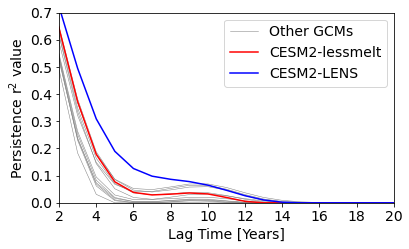

In [29]:
fig = plt.figure(figsize=[6,3.5])

for GCM_ in list(persistence_lowpass.keys()):
    
    data_plot = persistence_lowpass[GCM_].sel(region=2).sel(
            month=9).mean('member')
    data_plot = data_plot.where(data_plot>0,0)**2
    
    if GCM_ == 'CESM2-LENS':
        continue
    elif GCM_ == 'CanESM5':
        plt.plot(np.arange(1,21), data_plot, c='0.5', linestyle='-', 
                 linewidth=0.5, label='Other GCMs')
    else:
        plt.plot(np.arange(1,21), data_plot, c='0.5', linestyle='-', 
                 linewidth=0.5)

((to_plot.where(to_plot>0,0))**2).plot(label='CESM2-lessmelt', c='r')
((CESM_plot.where(CESM_plot>0,0))**2).plot(label='CESM2-LENS',c='b')

plt.ylim(0,0.7)
plt.xlim(2,20)
plt.legend(fontsize=14)
# plt.title('September Chukchi Sea SIC persistence');
plt.ylabel('Persistence r$^2$ value', fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Lag Time [Years]', fontsize=14);
plt.yticks(fontsize=14)
plt.title('');

fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/'\
            'Sup_Chukchi_Sep_lessmelt_comparison.pdf')

## Compute Persistence on the lowpass filtered PI Control SIC

In [2]:
SIC_CMIP6_xr = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/input_data/'\
    +'Regional_SIC_lowpass_filter_PI_Control_MMLE_500.nc')

In [5]:
all_mems = []
for mem_ in np.sort(SIC_CMIP6_xr['member'].values):
    print(datetime.datetime.now(), mem_)
    all_regions = []
    for region_ in [1,2,3,4,5,6,11]:
        all_months = []
        for month_ in np.arange(1,13):
            all_lags = []
            for lag_ in np.arange(1,21):
                month_region = SIC_CMIP6_xr['SIC'].sel(member=mem_).sel(
                    month=month_).sel(region=region_)

                #select the base time period
                sea_ice_init = month_region.sel(
                    year=slice('1920',str(2014-lag_)))
                sea_ice_init['year'] = range(len(sea_ice_init['year']))
                #select a lagged time period but use same time coordinates
                sea_ice_lagged = month_region.sel(
                    year=slice(str(1920+lag_),'2014'))
                sea_ice_lagged['year'] = range(len(sea_ice_lagged['year']))
                all_lags.append(xr.corr(sea_ice_init, sea_ice_lagged))

            all_lags_xr = xr.concat((all_lags),dim='lag')
            all_lags_xr['lag'] = np.arange(1,21)
            all_months.append(all_lags_xr)

        all_months_xr = xr.concat((all_months),dim='month')
        all_months_xr['month'] = np.arange(1,13)
        all_regions.append(all_months_xr)

    all_regions_xr = xr.concat((all_regions),dim='region')
    all_regions_xr['region'] = [1,2,3,4,5,6,11]
    all_mems.append(all_regions_xr)

all_mems_xr = xr.concat((all_mems),dim='member')
all_mems_xr['member'] = np.sort(SIC_CMIP6_xr['member'].values)

model_corr = xr.Dataset({'r_value':all_mems_xr})
model_corr.attrs = {
    'Description': 'Pearson correlation coefficient between lowpass filtered '\
        'sea ice concentration in the pre-industrial control runs used in '\
        'the training, valdiation and testing so-called members of 95-year '\
        'divisions of the model runs. To decode the members, please see the '\
        'metadata on /glade/work/cwpowell/low-frequency-variability/'\
        'input_data/Regional_SIC_lowpass_filter_PI_Control_MMLE_500.nc. The '\
        'same data is lagged by 1-20 years, evaluated by region and member',
    'Timestamp'  : str(datetime.datetime.utcnow().strftime(
        "%H:%M UTC %a %Y-%m-%d")),
    'Data source': 'CMIP6 Pre-Industrial Control Runs, '\
        'doi:10.5194/gmd-9-1937-2016.', 
    'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
        'blob/main/null_model/Null_model_persistence.ipynb'
}

model_corr.to_netcdf(
    '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'
    'correlation_SIC_lagged_1_20_years_lowpass_PI_Control.nc'
)
